## We use the **TensorFlow** framework (***without Keras***) to develop a multi-class classification problem on the MNIST handwritten digits dataset. We build a network of only fully connected feed forward layers. That is, no Convolution layer exists in the architecture. 
### (http://yann.lecun.com/exdb/mnist/)



1. We make observations on the model's loss on the minibatches during training.
2. Plot the classification error on the Validation set
2. We **train and compare** different neural networks to understand the significance of **Regularization** (*L2 and Dropout*).

In [ ]:
!nvidia-smi

Fri Dec 10 21:32:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Import the necessary libraries
import tensorflow as tf
print("TensorFlow Version: ",tf.__version__)

TensorFlow Version:  2.7.0


In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


## **Lets get the data ready**


In [ ]:
#import the necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import nn_utils
%matplotlib inline

In [ ]:
# Let us define some helper functions to assist in preparing the training and test data 

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)


def plot_random_examples(x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10)
    y = np.argmax(y, axis=1)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt


def plot_results(history):
    plt.figure(figsize=(12, 4))
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_acc'], label='Val Acc')
    plt.plot(range(epochs), history['train_acc'], label='Train Acc')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt

In [ ]:
## Let us initialize our dataset and also create train and test set using the helper functions we created above

(x_train, y_train), (x_test, y_test) = load_data()

11501568/11490434 [==============================] - 0s 0us/step


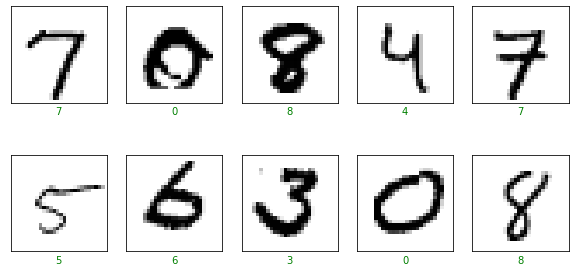

In [ ]:
## Let us do a manual check at few images in the training set just to see how the training images look

plot_random_examples(x_train,y_train).show() 

## plot_random_examples as you can see creates a plt object and we need to use the .show() methd
## to see the results.

## Lets build a Machine Learning model

First, we shall be building a three-layer feed-forward network as shown below:-

$x \rightarrow h^{1} \rightarrow h^{2} \rightarrow p(y|h^{2})$

The hidden layers $h^{1}$ and $h^{2}$ have dimension = 500. We train the network for 250 epochs and test the classification error. In the first stage, we do not use regularizations. For this, we plot the cross-entropy loss on the batches and also plot the classification error on the validation data.

## **Initializing the Neural Network**

We have to create the Neural Network class, understand the init function and set up the initial parameter values.

In [ ]:
class NeuralNetwork:  ## Calling this class will automatically create a NN object with weights and baises initialized
    
    def __init__(self, layers):

        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.setup()
  
        
    def setup(self):
       
        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],1)))
       

### **Creating a Forward Pass function**

In [ ]:
class NeuralNetwork(NeuralNetwork):
    
    def forward_pass(self, X):

        A = tf.convert_to_tensor(X, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A,tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

### **Computing Loss and Updating Parameters**

1.   We use the cross entropy loss with logits.
2.   We update parameters for all the layers.



In [ ]:
class NeuralNetwork(NeuralNetwork):

    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y,A)
        return tf.reduce_mean(loss)
    
    
    def update_params(self, lr):
        for i in range(1,self.L):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])

### **Predict and Info Functions**

1. First we have to unnderstandand the pre-written info function.
2. Therefore we create a predict function with the help of the forward pass

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):

        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

## **Training on Batch**

1. We create the main training mechanism.

2. And we implement the gradient descent with automatic differentiation.

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
         
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
          
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
        del tape
        self.update_params(lr)
        return loss.numpy() 

## **Training on Complete Set**

1. We break down data-set in batches.

2. And again we break down the training process in epochs and steps.

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):

        history = {
            'val_loss':[],
            'train_loss':[],
            'train_acc':[],
            'val_acc':[]
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch{}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss = self.train_on_batch(x_batch, y_batch,lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            train_preds = self.predict(x_train)
            train_acc = np.mean(np.argmax(y_train, axis=1) == train_preds.numpy())
            history['train_acc'].append(train_acc)
            
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)
            
            val_preds = self.predict(x_test)
            val_acc = np.mean(np.argmax(y_test, axis=1) == val_preds.numpy())
            history['val_acc'].append(val_acc)
            
            print('Train acc:',train_acc," ",'Val acc:',val_acc)
        return history

## **Application**
1. We apply the neural network model to solve a multi-class classification problem.
2. We create model instance and setting up hyperparameters.
3. And we create the model.

In [ ]:
net = NeuralNetwork([784,250,250,10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 250
Layer 2, Units 250
--------------
Number of parameters: 261510


In [ ]:
batch_size = 500
epochs = 20
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3
print('Steps per epoch', steps_per_epoch)

Steps per epoch 120


In [ ]:
history = net.train(
    x_train,y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr)

Epoch0...........Train acc: 0.7819333333333334   Val acc: 0.7865
Epoch1...........Train acc: 0.8315   Val acc: 0.8315
Epoch2...........Train acc: 0.8529   Val acc: 0.8523
Epoch3...........Train acc: 0.8657833333333333   Val acc: 0.8629
Epoch4...........Train acc: 0.8756333333333334   Val acc: 0.8701
Epoch5...........Train acc: 0.8821166666666667   Val acc: 0.8759
Epoch6...........Train acc: 0.8877833333333334   Val acc: 0.8825
Epoch7...........Train acc: 0.8928   Val acc: 0.8855
Epoch8...........Train acc: 0.897   Val acc: 0.8881
Epoch9...........Train acc: 0.8997333333333334   Val acc: 0.8897
Epoch10...........Train acc: 0.9025666666666666   Val acc: 0.8921
Epoch11...........Train acc: 0.9061833333333333   Val acc: 0.8945
Epoch12...........Train acc: 0.9088   Val acc: 0.8981
Epoch13...........Train acc: 0.9106166666666666   Val acc: 0.8987
Epoch14...........Train acc: 0.9129666666666667   Val acc: 0.8996
Epoch15...........Train acc: 0.9147833333333333   Val acc: 0.9006
Epoch16........

## **`Results`**
1. We plot the training results.
2. A look at predictions on the test set.

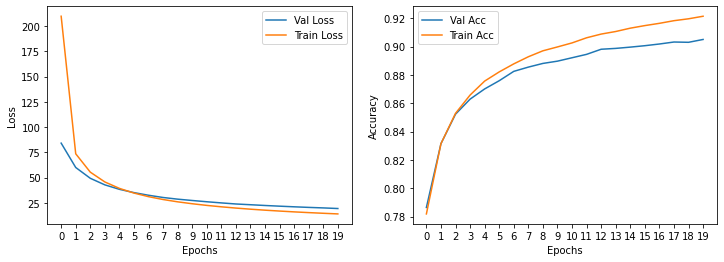

In [ ]:
plot_results(history).show()

### **Let us plot some images and see if the predicted status**


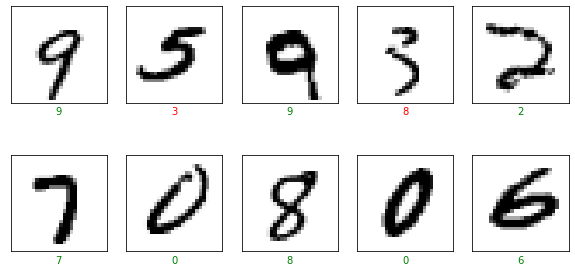

In [ ]:
preds = net.predict(x_test)
plot_random_examples(x_test,y_test,preds.numpy()).show()

## **THANK YOU**